In [31]:
from scipy.stats import norm
from scipy.stats import t
import numpy as np
import math
import matplotlib.pyplot as plt

St, K, r, q, sigma = 50, 50, 0.1, 0.05, 0.8
tao, T, M, n ,S_avet = 0,0.25,100,100,50

n_simulations = 10000
n_steps = 20


epsilon = 1e-8 #判斷標準

def linear_interpolation(arr, a):
    w = (arr[0] - a) / (arr[0] - arr[M])
    k = int(w * M)
    if 0 <= k < M and arr[k] >= a >= arr[k + 1]:
        return k + 1
    elif 0 <= k-1 < M and arr[k - 1] > a >= arr[k]:
        return k

def find_position_binary(arr, A, epsilon=1e-8):
    left, right = 0, len(arr) - 1
    while left <= right:
        mid = (left + right) // 2
        if abs(A - arr[mid]) < epsilon:
            return mid
        elif arr[mid] > A:
            left = mid + 1
        else:
            right = mid - 1
    if right < 0:
        return 0
    if right >= len(arr) - 1:
        return len(arr) - 1
    return right + 1


def find_position(arr, A, epsilon=1e-8):

    for i in range(len(arr) - 1):
        if arr[i] >= A >= arr[i + 1]:
            return i + 1
    # Handling edge cases where A is outside the bounds due to floating point errors


Basic

In [69]:
def binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European'):
    n1 = int((tao/T)*n)
    n2 = int((1-tao/T)*n)
    dt = (T-tao)/n2
    u = np.exp( sigma * np.sqrt(dt))
    d = np.exp( - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d) 

    option = np.zeros((n2+1,n2+1,M+1))
    A = np.zeros((n2+1,n2+1,M+1))
    for k in range(M+1):
        A[0,0,k] = S_avet

    ##A_max and A_min
    for t in range(1,n2+1):
        for j in range(0,t+1):
            S0 = S_avet * (n1+1)
            A[t,j,0] = (S0  + St * u * (1-u**(t-j))/(1-u) + St * u**(t-j) * d * ((1-d**j)/(1-d)))/(t+1+n1)
            A[t,j,M] = (S0  + St * d * (1-d**(j))/(1-d) + St * d ** (j) * u * ((1-u**(t-j))/(1-u)))/(t+1+n1)
            for k in range(0,M+1):
                A[t,j,k] = (M-k)/M * A[t,j,0] + k/M * A[t,j,M]

    #construct optionp[n] 
    for j in range(n2+1):
        for k in range(M+1):
            option[n2,j,k] = np.maximum((A[n2,j,k]-K),0)

    #S_ave tree
    for t in range(n2-1,-1,-1):
        for j in range(t+1):
            for k in range(M+1):

                Au = ((t+1+n1)*A[t,j,k] + St*(u**(t+1-j)*d**j))/(t+n1+2)
                if np.abs(Au-A[t+1,j,0]) < epsilon :
                    Cu = option[t+1,j,0]
                elif np.abs(Au-A[t+1,j,M]) < epsilon:
                    Cu = option[t+1,j,M]
                else:
                    ku = linear_interpolation(A[t+1,j],Au)
                    wu = (A[t+1,j,ku-1]-Au)/(A[t+1,j,ku-1]-A[t+1,j,ku])
                    Cu = wu * option[t+1,j,ku] + (1-wu) * option[t+1,j,ku-1]

                Ad = ((t+1+n1)*A[t,j,k] + St*u**(t+1-j-1)*d**(j+1))/(t+n1+2)
                if np.abs(Ad-A[t+1,j+1,0]) < epsilon:
                    Cd = option[t+1,j+1,0]
                elif np.abs(Ad-A[t+1,j+1,M]) < epsilon:
                    Cd = option[t+1,j+1,M]
                else:
                    kd = linear_interpolation(A[t+1,j+1],Ad)
                    wd = (A[t+1,j+1,kd-1]-Ad)/(A[t+1,j+1,kd-1]-A[t+1,j+1,kd])
                    Cd = wd * option[t+1,j+1,kd] + (1-wd) * option[t+1,j+1,kd-1]

                
                #type of option
                hold = (p * Cu +(1-p)*Cd)*np.exp(-r*dt)
                exercise = A[t,j,k]-K
                if option_type == "European":
                    option[t,j,k] = np.maximum(hold,0)
                else:
                    option[t,j,k] = np.maximum(hold,exercise)
    return option[0,0,0]

American = binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'American')
European = binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European')
American_t = binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='American')
European_t = binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='European')
print(f"European option: {European}")
print(f"American option: {American}")
print(f"European option T-t = 0.25: {European_t}")
print(f"American option T-t = 0.25: {American_t}")

European option: 4.735385345731979
American option: 5.4145899579662276
European option T-t = 0.25: 2.379472238402663
American option T-t = 0.25: 2.507865849655305


In [75]:
def log_binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European'):
    
    n1 = int((tao/T)*n)
    n2 = int((1-tao/T)*n)
    dt = (T-tao)/n2
    u = np.exp( sigma * np.sqrt(dt))
    d = np.exp( - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d) 

    option = np.zeros((n2+1,n2+1,M+1))
    A = np.zeros((n2+1,n2+1,M+1))
    for k in range(M+1):
        A[0,0,k] = S_avet

    ##A_max and A_min
    for t in range(1,n2+1):
        for j in range(0,t+1):
            S0 = S_avet * (n1+1)
            A[t,j,0] = (S0  + St * u * (1-u**(t-j))/(1-u) + St * u**(t-j) * d * ((1-d**j)/(1-d)))/(t+1+n1)
            A[t,j,M] = (S0  + St * d * (1-d**(j))/(1-d) + St * d ** (j) * u * ((1-u**(t-j))/(1-u)))/(t+1+n1)
            for k in range(0,M+1):
                A[t,j,k] = np.exp((M-k)/M * np.log(A[t,j,0]) + k/M * np.log(A[t,j,M]))

    #construct optionp[n] 
    for j in range(n2+1):
        for k in range(M+1):
            option[n2,j,k] = np.maximum((A[n2,j,k]-K),0)

    #S_ave tree
    for t in range(n2-1,-1,-1):
        for j in range(t+1):
            for k in range(M+1):

                Au = ((t+1+n1)*A[t,j,k] + St*(u**(t+1-j)*d**j))/(t+n1+2)
                if np.abs(Au-A[t+1,j,0]) < epsilon :
                    Cu = option[t+1,j,0]
                elif np.abs(Au-A[t+1,j,M]) < epsilon:
                    Cu = option[t+1,j,M]
                else:
                    ku = find_position_binary(A[t+1,j],Au)
                    wu = (A[t+1,j,ku-1]-Au)/(A[t+1,j,ku-1]-A[t+1,j,ku])
                    Cu = wu * option[t+1,j,ku] + (1-wu) * option[t+1,j,ku-1]

                Ad = ((t+1+n1)*A[t,j,k] + St*u**(t+1-j-1)*d**(j+1))/(t+n1+2)
                if np.abs(Ad-A[t+1,j+1,0]) < epsilon:
                    Cd = option[t+1,j+1,0]
                elif np.abs(Ad-A[t+1,j+1,M]) < epsilon:
                    Cd = option[t+1,j+1,M]
                else:
                    kd = find_position_binary(A[t+1,j+1],Ad)
                    wd = (A[t+1,j+1,kd-1]-Ad)/(A[t+1,j+1,kd-1]-A[t+1,j+1,kd])
                    Cd = wd * option[t+1,j+1,kd] + (1-wd) * option[t+1,j+1,kd-1]

                
                #type of option
                hold = (p * Cu +(1-p)*Cd)*np.exp(-r*dt)
                exercise = A[t,j,k]-K
                if option_type == "European":
                    option[t,j,k] = np.maximum(hold,0)
                else:
                    option[t,j,k] = np.maximum(hold,exercise)
    return option[0,0,0]

American = log_binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'American')
European = log_binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European')
American_t = log_binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='American')
European_t = log_binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='European')
print(f"European option: {European}")
print(f"American option: {American}")
print(f"European option T-t = 0.25: {European_t}")
print(f"American option T-t = 0.25: {American_t}")

European option: 4.69489885404984
American option: 5.390353494722346
European option T-t = 0.25: 2.360455650343315
American option T-t = 0.25: 2.4945677813869667


In [72]:
def MonteCarlo(St,S_avet,k,r,T,tao,q,sigma,n,n_simulations,n_steps):
    
    n1 = int((tao/T)*n)
    n2 = int((1-tao/T)*n)
    dt = (T-tao)/n2

    #length of time step
    call_prices = []
    for _ in range(n_steps):
    #create two dimensional matrix of random std normal numbers (paths X timesteps)
        rn=np.random.standard_normal((n2+1,n_simulations))
        #initialize S[0] to 100 stock price
        S=np.zeros_like(rn)
        S[0]=St
    
        for t in range(1,n2+1): 
            S[t]=S[t-1]*np.exp((r-q-sigma**2/2)*dt+(sigma*rn[t]*math.sqrt(dt)))

        S_path = np.sum(S,axis=0)
        ave = (S_path + (S_avet * n1)) / (n + 1)
        call = np.maximum(ave - k, 0)
        call_prices.append(math.exp(-r*(T-tao))*call.mean())
    mean = np.mean(call_prices)
    std = np.std(call_prices)
    upper = np.round(mean + 2 * std,4)
    lower = np.round(mean - 2 * std,4)      
    CI_put = [lower, upper]    
    #Now Discount the Average of all payoffs
    return mean,std,CI_put 


mean_call,std_call,CI_call = MonteCarlo(St, S_avet,K, r, T, tao, q, sigma,n, n_simulations, n_steps)
print(f"mean of call: {mean_call:.4f}", f"std of call: {std_call:.4f}", f"CI of call: {CI_call}")


mean_call,std_call,CI_call = MonteCarlo(St, S_avet,K, r, 0.5, 0.25, q, sigma,200, n_simulations, n_steps)
print(f"mean of call: {mean_call:.4f}", f"std of call: {std_call:.4f}", f"CI of call: {CI_call}")

mean of call: 4.6423 std of call: 0.0822 CI of call: [4.4778, 4.8067]
mean of call: 2.3297 std of call: 0.0397 CI of call: [2.2503, 2.4091]


Bonus 1

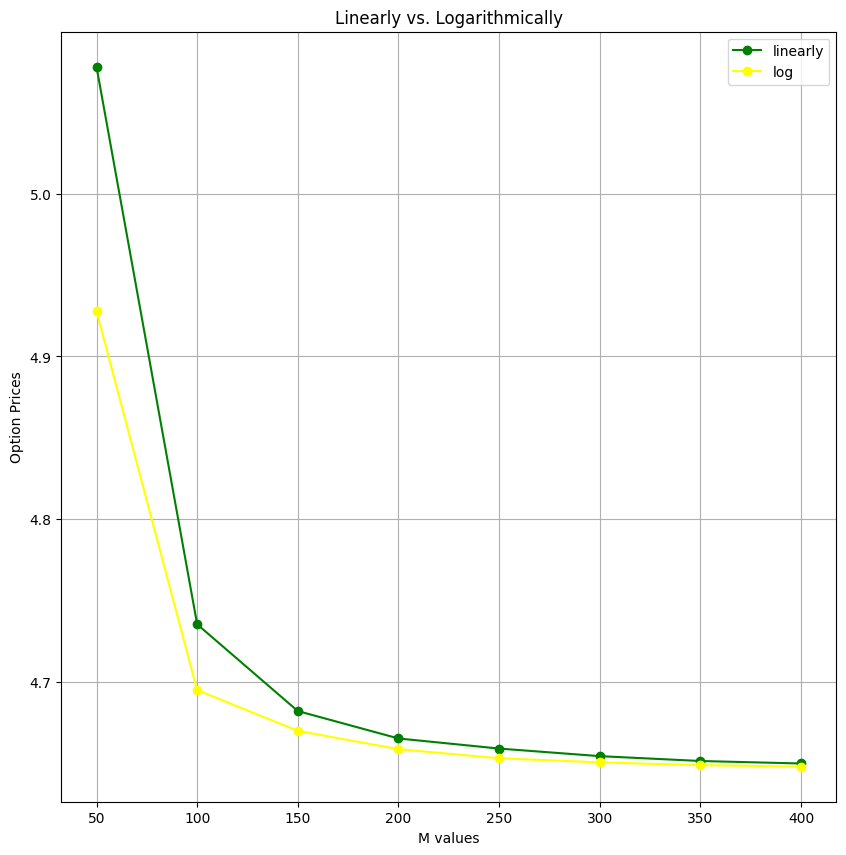

In [77]:
M_list = []
log_list = []
normal_list = []

for m in range(50, 401, 50):
    EU_nor = binomial_tree(St,K,r,q,sigma,tao,T,m,n,option_type = 'European')
    EU_log = log_binomial_tree(St,K,r,q,sigma,tao,T,m,n,option_type = 'European')
    M_list.append(m)
    log_list.append(EU_log)
    normal_list.append(EU_nor)

plt.figure(figsize=(10,10))
plt.plot(M_list, normal_list, marker="o", color = 'green', label = 'linearly')
plt.plot(M_list, log_list, marker="o", color = 'yellow', label = 'log')

plt.title('Linearly vs. Logarithmically')
plt.xlabel('M values')
plt.ylabel('Option Prices')
plt.legend()
plt.grid(True)
plt.show()

Bonus 2

In [76]:
def binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European'):
    n1 = int((tao/T)*n)
    n2 = int((1-tao/T)*n)
    dt = (T-tao)/n2
    u = np.exp( sigma * np.sqrt(dt))
    d = np.exp( - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d) 

    option = np.zeros((n2+1,n2+1,M+1))
    A = np.zeros((n2+1,n2+1,M+1))

    for k in range(M+1):
        A[0,0,k] = S_avet

    ##A_max and A_min
    for t in range(1,n2+1):
        for j in range(0,t+1):
            S0 = S_avet * (n1+1)
            A[t,j,0] = (S0  + St * u * (1-u**(t-j))/(1-u) + St * u**(t-j) * d * ((1-d**j)/(1-d)))/(t+1+n1)
            A[t,j,M] = (S0  + St * d * (1-d**(j))/(1-d) + St * d ** (j) * u * ((1-u**(t-j))/(1-u)))/(t+1+n1)
            for k in range(0,M+1):
                A[t,j,k] = (M-k)/M * A[t,j,0] + k/M * A[t,j,M]

    #construct optionp[n] 
    for j in range(n2+1):
        for k in range(M+1):
            option[n2,j,k] = np.maximum((A[n2,j,k]-K),0)

    #S_ave tree
    for t in range(n2-1,-1,-1):
        for j in range(t+1):
            for k in range(M+1):

                Au = ((t+1+n1)*A[t,j,k] + St*(u**(t+1-j)*d**j))/(t+n1+2)
                if np.abs(Au-A[t+1,j,0]) < epsilon:
                    Cu = option[t+1,j,0]
                else:
                    ku = find_position_binary(A[t+1,j],Au)
                    wu = (A[t+1,j,ku-1]-Au)/(A[t+1,j,ku-1]-A[t+1,j,ku])
                    Cu = wu * option[t+1,j,ku] + (1-wu) * option[t+1,j,ku-1]

                Ad = ((t+1+n1)*A[t,j,k] + St*u**(t+1-j-1)*d**(j+1))/(t+n1+2)
                if np.abs(Ad-A[t+1,j+1,0]) < epsilon:
                    Cd = option[t+1,j+1,0]
                else:
                    kd = find_position_binary(A[t+1,j+1],Ad)
                    wd = (A[t+1,j+1,kd-1]-Ad)/(A[t+1,j+1,kd-1]-A[t+1,j+1,kd])
                    Cd = wd * option[t+1,j+1,kd] + (1-wd) * option[t+1,j+1,kd-1]

                
                #type of option
                hold = (p * Cu +(1-p)*Cd)*np.exp(-r*dt)
                exercise = A[t,j,k]-K
                if option_type == "European":
                    option[t,j,k] = np.maximum(hold,0)
                else:
                    option[t,j,k] = np.maximum(hold,exercise)
    return option[0,0,0]

American = binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'American')
European = binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European')
American_t = binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='American')
European_t = binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='European')
print(f"European option: {European}")
print(f"American option: {American}")
print(f"European option T-t = 0.25: {European_t}")
print(f"American option T-t = 0.25: {American_t}")

European option: 4.735385345731979
American option: 5.4145899579662276
European option T-t = 0.25: 2.3794722384026636
American option T-t = 0.25: 2.5078658496553055


In [78]:
def binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European'):

    n1 = int((tao/T)*n)
    n2 = int((1-tao/T)*n)
    dt = (T-tao)/n2
    u = np.exp( sigma * np.sqrt(dt))
    d = np.exp( - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d) 
    option = np.zeros((n2+1,n2+1,M+1))
    A = np.zeros((n2+1,n2+1,M+1))
    for k in range(M+1):
        A[0,0,k] = S_avet

    ##A_max and A_min
    for t in range(1,n2+1):
        for j in range(0,t+1):
            S0 = S_avet * (n1+1)
            A[t,j,0] = (S0 + St * u * (1-u**(t-j))/(1-u) + St * u**(t-j) * d * ((1-d**j)/(1-d)))/(t+1+n1)
            A[t,j,M] = (S0 + St * d * (1-d**(j))/(1-d) + St * d ** (j) * u * ((1-u**(t-j))/(1-u)))/(t+1+n1)
            for k in range(0,M+1):
                A[t,j,k] = (M-k)/M * A[t,j,0] + k/M * A[t,j,M]

    #construct optionp[n] 
    for j in range(n2+1):
        for k in range(M+1):
            option[n2,j,k] = np.maximum((A[n2,j,k]-K),0)

    #S_ave tree
    for t in range(n2-1,-1,-1):
        for j in range(t+1):
            for k in range(M+1):

                Au = ((t+1+n1)*A[t,j,k] + St*(u**(t+1-j)*d**j))/(t+n1+2)
                if np.abs(Au-A[t+1,j,0]) < epsilon :
                    Cu = option[t+1,j,0]
                elif np.abs(Au-A[t+1,j,M]) < epsilon:
                    Cu = option[t+1,j,M]
                else:
                    ku = find_position(A[t+1,j],Au)
                    wu = (A[t+1,j,ku-1]-Au)/(A[t+1,j,ku-1]-A[t+1,j,ku])
                    Cu = wu * option[t+1,j,ku] + (1-wu) * option[t+1,j,ku-1]

                Ad = ((t+1+n1)*A[t,j,k] + St*u**(t+1-j-1)*d**(j+1))/(t+n1+2)
                if np.abs(Ad-A[t+1,j+1,0]) < epsilon:
                    Cd = option[t+1,j+1,0]
                elif np.abs(Ad-A[t+1,j+1,M]) < epsilon:
                    Cd = option[t+1,j+1,M]
                else:
                    kd = find_position(A[t+1,j+1],Ad)
                    wd = (A[t+1,j+1,kd-1]-Ad)/(A[t+1,j+1,kd-1]-A[t+1,j+1,kd])
                    Cd = wd * option[t+1,j+1,kd] + (1-wd) * option[t+1,j+1,kd-1]

                
                #type of option
                hold = (p * Cu +(1-p)*Cd)*np.exp(-r*dt)
                exercise = A[t,j,k]-K
                if option_type == "European":
                    option[t,j,k] = np.maximum(hold,0)
                else:
                    option[t,j,k] = np.maximum(hold,exercise)
    return option[0,0,0]

American = binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'American')
European = binomial_tree(St,K,r,q,sigma,tao,T,M,n,option_type = 'European')
American_t = binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='American')
European_t = binomial_tree(St,K,r,q,sigma,0.25,0.5,M,200,option_type='European')
print(f"European option: {European}")
print(f"American option: {American}")
print(f"European option T-t = 0.25: {European_t}")
print(f"American option T-t = 0.25: {American_t}")